In [157]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt


In [158]:
# Get cpu, gpu or mps device for training.
device = (
    "cpu"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [159]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long, device=device)

In [160]:
raw_text = """During my second month of nursing school, our professor gave us a pop quiz.
I was a conscientious student and had breezed through the questions, until I read the last one:
“What is the first name of the woman who cleans the school?”  Surely this was some kind of joke.
I had seen the cleaning woman several times. She was tall, dark-haired and in her 50s, but how would I know her name?
I handed in my paper, leaving the last question blank.  Before class ended, one student asked if the last question would count toward our quiz grade.
“Absolutely,” said the professor.  “In your careers you will meet many people. All are significant. They deserve your attention and care,
even if all you do is smile and say ‘hello’. I’ve never forgotten that lesson. I also learned her name was Dorothy.""".split()

In [161]:
from nltk.book import text1

In [162]:
# convert Text into a list of words

raw_text = text1.generate(length = 1500, random_seed=22230).split()

hid , heliotrope glance anticipatingly gone backward on its summit and
look about me in all this raging tumult , Jonah ' s the end . Because
, while the one visible quality in this life , as a rather brigandish
expression to his crew ' s instrument is brought close to them ,
afterwards , at the whale , but remain over the gunwale ; " Mr . upon
which the wight Death is only dispirited ; out of the voyage , without
a lesson to us and our offing gained , and so remained kneeling , till
it is often mistaken for a Quaker . " of being a whaleman ( more or
less have to pay her respects . , Daggoo ! the White Whale to - morrow
, in its annual round , loiters for a corroborative example , that if
he feel but a herd of whales find their food with such madness through
the strenuous exertions of Starbuck and Queequeg changed places --
stem for stern -- a pleasant sun , Ahab thus pondered over his head ,
I thought my eyes , then , with his utmost velocity from the
concentrating brow of Moby Dick to

In [163]:
CONTEXT_SIZE = 5  # 2 words to the left, 2 to the right
EMDEDDING_DIM = 500

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_list = list(vocab)

word_to_ix = {word:ix for ix, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}




In [164]:
def CBOW(raw_text, window_size=2):
    data = []
    for i in range(window_size, len(raw_text) - window_size):
        context = [raw_text[i - window_size], raw_text[i - (window_size - 1)], raw_text[i + (window_size - 1)], raw_text[i + window_size]]
        target = raw_text[i]
        data.append((context, target))

    return data


data = CBOW(raw_text)
data[0]

(['hid', ',', 'glance', 'anticipatingly'], 'heliotrope')

In [165]:
class CBOW_Model(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_Model, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()

        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)


    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]], device=device, dtype=torch.long)
        return self.embeddings(word).view(1,-1)

In [166]:
model = CBOW_Model(vocab_size, EMDEDDING_DIM)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [167]:
# set all tensors to the device we are using (cpu, gpu, mps)
model.to(device)
loss_function.to(device)


CrossEntropyLoss()

In [168]:
#TRAINING
for epoch in range(1000):
    total_loss = 0

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix).to(device)

        log_probs = model(context_vector).to(device)

        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]], device=device))

    #optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

In [169]:
for w in word_list:
    print(f"{w}: {model.get_word_emdedding(w)}")

infallibly: tensor([[-7.9548e-01,  1.1679e-01,  8.0253e-01, -1.3198e+00,  4.3478e-01,
         -5.9476e-01, -1.4489e+00,  2.0255e+00,  9.3396e-01,  3.3045e-01,
         -1.4586e+00,  1.1271e+00,  1.0832e+00,  2.1900e+00,  7.4450e-01,
         -8.7353e-01, -2.5869e-01, -8.4403e-01,  1.1092e+00,  2.8523e-01,
         -2.6980e-01,  9.9922e-02, -7.4447e-02,  1.5559e+00, -9.9021e-01,
         -2.1493e+00,  1.2353e+00, -5.8145e-01, -6.9406e-01, -6.2677e-01,
         -1.1998e+00,  6.0133e-01, -6.8770e-01,  1.1226e+00,  1.2769e-01,
         -1.3615e+00,  8.1742e-01, -1.5941e+00,  3.7725e-01,  1.5390e+00,
          2.4092e+00,  1.5768e+00, -4.8529e-01,  1.7356e+00, -9.7112e-01,
          2.5151e+00, -8.8161e-01, -8.3257e-01, -4.2407e-01,  9.9228e-02,
          2.8916e-01, -6.9244e-01,  2.8978e-01, -9.4528e-01, -1.2622e+00,
         -9.2272e-01,  3.5241e-02, -2.2298e+00, -1.5708e-01,  1.8901e-01,
         -3.5665e-02, -3.5570e-01, -1.4683e+00, -4.8594e-01,  8.3528e-01,
          1.5186e+00,  7.9

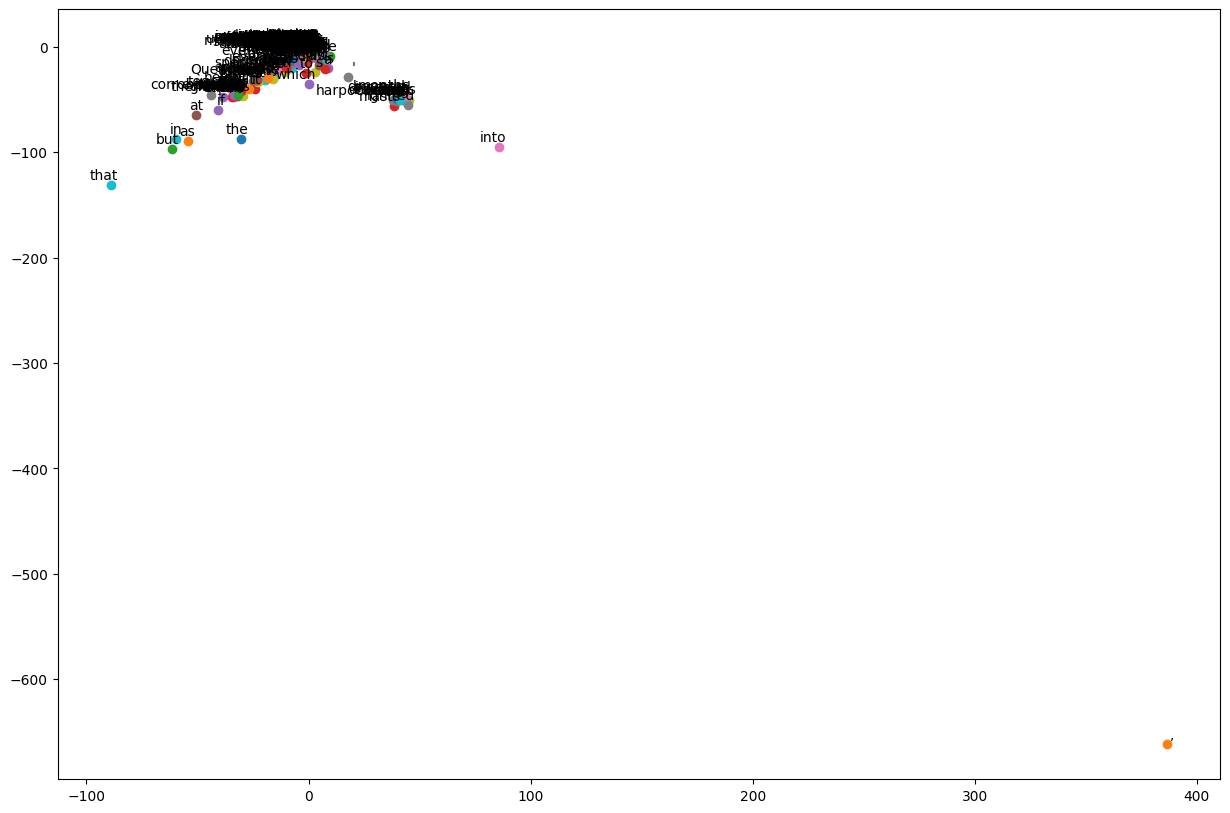

In [170]:
plt.figure(figsize=(15,10))
for w in word_list:
    x = model.get_word_emdedding(w).detach().cpu().data.numpy()[0][0]
    y = model.get_word_emdedding(w).detach().cpu().data.numpy()[0][1]
    plt.scatter(x, y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

In [171]:
def CBOW_test(test_data, model):
    correct_ct = 0

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)
        model.zero_grad()
        predicted = torch.argmax(model(context_vector), 1)

        if predicted[0] == torch.tensor([word_to_ix[target]], device=device):
                correct_ct += 1

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

In [172]:
CBOW_test(data, model)

Accuracy: 6.9% (103/1496)


In [173]:
#TESTING
context = ['rather', 'expression', 'to', 'his']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)


In [174]:
#Print result
print(f'Raw text: {" ".join(raw_text)}\n')
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

Raw text: hid , heliotrope glance anticipatingly gone backward on its summit and look about me in all this raging tumult , Jonah ' s the end . Because , while the one visible quality in this life , as a rather brigandish expression to his crew ' s instrument is brought close to them , afterwards , at the whale , but remain over the gunwale ; " Mr . upon which the wight Death is only dispirited ; out of the voyage , without a lesson to us and our offing gained , and so remained kneeling , till it is often mistaken for a Quaker . " of being a whaleman ( more or less have to pay her respects . , Daggoo ! the White Whale to - morrow , in its annual round , loiters for a corroborative example , that if he feel but a herd of whales find their food with such madness through the strenuous exertions of Starbuck and Queequeg changed places -- stem for stern -- a pleasant sun , Ahab thus pondered over his head , I thought my eyes , then , with his utmost velocity from the concentrating brow of Mo

In [175]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
